<a href="https://colab.research.google.com/github/sonjerry/Turing-test/blob/main/DBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

(xtr, ytr), (xte, yte) = tf.keras.datasets.mnist.load_data()
xtr = (xtr.astype("float32")/255.).reshape(-1, 784)
xte = (xte.astype("float32")/255.).reshape(-1, 784)

BATCH = 128
train_ds = tf.data.Dataset.from_tensor_slices(xtr).shuffle(10000).batch(BATCH)


class RBM(tf.keras.Model):
    """
    Bernoulli-Bernoulli RBM with CD-k (default k=1).
    W: (n_visible, n_hidden,), vb: (n_visible,), hb: (n_hidden,)
    """
    def __init__(self, n_visible, n_hidden, k=1):
        super().__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.k = k

        limit = np.sqrt(6. / (n_visible + n_hidden))
        self.W = tf.Variable(tf.random.uniform([n_visible, n_hidden], -limit, limit), name="W")
        self.vb = tf.Variable(tf.zeros([n_visible]), name="vb")
        self.hb = tf.Variable(tf.zeros([n_hidden]), name="hb")

    @staticmethod
    def _sigm(x):
        return tf.math.sigmoid(x)

    def sample_h(self, v):
        p_h = self._sigm(tf.matmul(v, self.W) + self.hb)
        return p_h, tf.cast(tf.random.uniform(tf.shape(p_h)) < p_h, tf.float32)

    def sample_v(self, h):
        p_v = self._sigm(tf.matmul(h, tf.transpose(self.W)) + self.vb)
        return p_v, tf.cast(tf.random.uniform(tf.shape(p_v)) < p_v, tf.float32)

    def cd_loss_and_grads(self, v0):
        with tf.GradientTape() as tape:
            p_h0, h0 = self.sample_h(v0)
            vk, hk = v0, h0

            for _ in range(self.k):
                pvk, vk = self.sample_v(hk)
                phk, hk = self.sample_h(vk)

            pos = tf.matmul(tf.transpose(v0), p_h0)
            neg = tf.matmul(tf.transpose(vk), phk)

            recon_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(v0, pvk)
            )

            dW = (pos - neg) / tf.cast(tf.shape(v0)[0], tf.float32)
            dvb = tf.reduce_mean(v0 - vk, axis=0)
            dhb = tf.reduce_mean(p_h0 - phk, axis=0)

        return recon_loss, [dW, dvb, dhb]

    def fit_rbm(self, dataset, epochs=10, lr=1e-3):
        opt = tf.keras.optimizers.Adam(lr)
        for ep in range(1, epochs+1):
            losses = []
            for v0 in dataset:
                loss, [dW, dvb, dhb] = self.cd_loss_and_grads(v0)
                opt.apply_gradients([( -dW, self.W), ( -dvb, self.vb), ( -dhb, self.hb)])
                losses.append(loss.numpy())
            print(f"[RBM] epoch {ep:02d}  recon={np.mean(losses):.4f}")

    def transform(self, X, batch=512):
        H = []
        for i in range(0, X.shape[0], batch):
            v = tf.convert_to_tensor(X[i:i+batch], dtype=tf.float32)
            p_h, _ = self.sample_h(v)
            H.append(p_h.numpy())
        return np.concatenate(H, axis=0)

    def generate(self, n=16, steps=200):
        h = tf.cast(tf.random.uniform([n, self.n_hidden]) < 0.5, tf.float32)
        v = tf.cast(tf.random.uniform([n, self.n_visible]) < 0.5, tf.float32)
        for _ in range(steps):
            _, h = self.sample_h(v)
            pv, v = self.sample_v(h)
        return pv.numpy()


rbm1 = RBM(784, 256, k=1)
rbm1.fit_rbm(train_ds, epochs=10, lr=1e-3)

H1 = rbm1.transform(xtr)
train_ds_h1 = tf.data.Dataset.from_tensor_slices(H1).shuffle(10000).batch(BATCH)

rbm2 = RBM(256, 128, k=1)
rbm2.fit_rbm(train_ds_h1, epochs=10, lr=1e-3)




11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[RBM] epoch 01  recon=0.2144
[RBM] epoch 02  recon=0.1473
[RBM] epoch 03  recon=0.1315
[RBM] epoch 04  recon=0.1231
[RBM] epoch 05  recon=0.1176
[RBM] epoch 06  recon=0.1137
[RBM] epoch 07  recon=0.1106
[RBM] epoch 08  recon=0.1081
[RBM] epoch 09  recon=0.1059
[RBM] epoch 10  recon=0.1042
[RBM] epoch 01  recon=0.4632
[RBM] epoch 02  recon=0.3677
[RBM] epoch 03  recon=0.3361
[RBM] epoch 04  recon=0.3194
[RBM] epoch 05  recon=0.3092
[RBM] epoch 06  recon=0.3019
[RBM] epoch 07  recon=0.2966
[RBM] epoch 08  recon=0.2924
[RBM] epoch 09  recon=0.2892
[RBM] epoch 10  recon=0.2864


In [2]:
from tensorflow.keras import layers, models, optimizers

dense1 = layers.Dense(256, activation="sigmoid")
dense2 = layers.Dense(128, activation="sigmoid")
dense1.build((None, 784))
dense2.build((None, 256))
dense1.set_weights([rbm1.W.numpy(), rbm1.hb.numpy()])
dense2.set_weights([rbm2.W.numpy(), rbm2.hb.numpy()])

clf = models.Sequential([
    layers.Input(shape=(784,)),
    dense1,
    dense2,
    layers.Dense(10, activation="softmax")
])

clf.compile(
    optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist = clf.fit(xtr, ytr, validation_data=(xte, yte), epochs=10, batch_size=128, verbose=1)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6843 - loss: 1.1147 - val_accuracy: 0.9386 - val_loss: 0.2264
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9436 - loss: 0.2040 - val_accuracy: 0.9580 - val_loss: 0.1474
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9639 - loss: 0.1277 - val_accuracy: 0.9659 - val_loss: 0.1163
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9729 - loss: 0.0958 - val_accuracy: 0.9716 - val_loss: 0.0973
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9795 - loss: 0.0741 - val_accuracy: 0.9739 - val_loss: 0.0839
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9845 - loss: 0.0574 - val_accuracy: 0.9751 - val_loss: 0.0779
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.0462 - val_accuracy: 0.9776 - val_loss: 0.0726
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9911 - loss: 0.0364 - val_accuracy: 0.

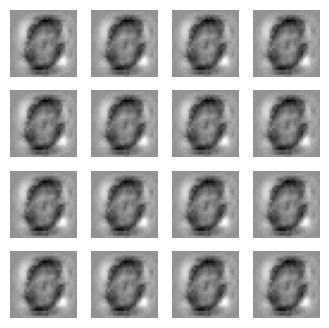

In [6]:
import matplotlib.pyplot as plt

samples = rbm1.generate(n=16, steps=200)
fig, axs = plt.subplots(4,4, figsize=(4,4))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(samples[i].reshape(28,28), cmap="gray")
    ax.axis("off")
plt.show()
